In [ ]:
!pip install -q imbalanced-learn scikit-learn

In [ ]:
from google.colab import files
files.upload()

Saving best_hybrid_model.keras to best_hybrid_model.keras
Buffered data was truncated after reaching the output size limit.

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from imblearn.over_sampling import SMOTE


In [ ]:
# STEP 1: Download and Extract HAM10000 Dataset from Kaggle
!pip install -q kaggle

import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /content/kaggle.json

!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!unzip -q skin-cancer-mnist-ham10000.zip -d ham10000

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0


In [ ]:
import shutil
shutil.rmtree('/content/ham10000/images_combined', ignore_errors=True)


In [ ]:
import shutil


# STEP 2: Data Preprocessing
img_dir = '/content/ham10000/'
meta_csv = os.path.join(img_dir, 'HAM10000_metadata.csv')
df = pd.read_csv(meta_csv)
df['image'] = df['image_id'] + '.jpg'
df = df[['image', 'dx']]
df.columns = ['image', 'label']

# Create a new folder to store all images in one place
combined_dir = os.path.join(img_dir, 'images_combined')
os.makedirs(combined_dir, exist_ok=True)

# Move files from part 1 and part 2 into one folder
part1 = os.path.join(img_dir, 'HAM10000_images_part_1')
part2 = os.path.join(img_dir, 'ham10000_images_part_2')

for fname in os.listdir(part1):
    shutil.copy(os.path.join(part1, fname), combined_dir)

for fname in os.listdir(part2):
    shutil.copy(os.path.join(part2, fname), combined_dir)

# ✅ Update img_dir to point to the correct location for use with generators
img_dir = combined_dir

# 1. Load HAM10000 Dataset
metadata = pd.read_csv(meta_csv)

# 2. Load and preprocess images
def load_image(image_id):
    img_path = os.path.join(img_dir, image_id + ".jpg")
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (72, 72))
        return img.astype("float32") / 255.0
    return None

images, labels = [], []
for _, row in metadata.iterrows():
    img = load_image(row["image_id"])
    if img is not None:
        images.append(img)
        labels.append(row["dx"])

X = np.array(images)
le = LabelEncoder()
y = le.fit_transform(labels)
class_names = le.classes_
y_cat = tf.keras.utils.to_categorical(y)

# 3. Balance the dataset
X_flat = X.reshape(len(X), -1)
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_flat, y)
X_bal = X_smote.reshape(-1, 72, 72, 3)
y_bal_cat = tf.keras.utils.to_categorical(y_smote)

# 4. Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal_cat, test_size=0.2, random_state=42)


prediction trained model

In [ ]:
# STEP 4.5: Define the Hybrid Model
from tensorflow.keras.applications import Xception

def create_cnn_vit_xception(input_shape=(72, 72, 3), num_classes=7):
    inputs = tf.keras.Input(shape=input_shape, name="input_image")

    # CNN Branch
    cnn = tf.keras.layers.Conv2D(32, (3, 3), padding='same')(inputs)
    cnn = tf.keras.layers.BatchNormalization()(cnn)
    cnn = tf.keras.layers.ReLU()(cnn)
    cnn = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(cnn)

    cnn = tf.keras.layers.Conv2D(64, (3, 3), padding='same')(cnn)
    cnn = tf.keras.layers.BatchNormalization()(cnn)
    cnn = tf.keras.layers.ReLU()(cnn)
    cnn = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(cnn)

    cnn = tf.keras.layers.Conv2D(128, (3, 3), padding='same')(cnn)
    cnn = tf.keras.layers.BatchNormalization()(cnn)
    cnn = tf.keras.layers.ReLU()(cnn)
    cnn = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(cnn)

    cnn_output = tf.keras.layers.GlobalAveragePooling2D()(cnn)

    # ViT Branch
    vit_patches = tf.keras.layers.Conv2D(64, kernel_size=6, strides=6, padding='valid')(inputs)
    vit_reshaped = tf.keras.layers.Reshape((-1, 64))(vit_patches)

    positions = tf.range(start=0, limit=vit_reshaped.shape[1])
    pos_embed = tf.keras.layers.Embedding(input_dim=vit_reshaped.shape[1], output_dim=64)(positions)
    vit_encoded = vit_reshaped + pos_embed

    for _ in range(4):
        x1 = tf.keras.layers.LayerNormalization()(vit_encoded)
        attn = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=64)(x1, x1)
        x2 = tf.keras.layers.Add()([vit_encoded, attn])
        x3 = tf.keras.layers.LayerNormalization()(x2)
        mlp = tf.keras.layers.Dense(64, activation='gelu')(x3)
        vit_encoded = tf.keras.layers.Add()([x2, mlp])

    vit_output = tf.keras.layers.Flatten()(vit_encoded)

    # Xception Branch
    base_xcp = Xception(include_top=False, weights='imagenet', input_tensor=inputs)
    base_xcp.trainable = True
    xcp_output = tf.keras.layers.GlobalAveragePooling2D()(base_xcp.output)

    # Fusion
    fusion = tf.keras.layers.Concatenate()([cnn_output, vit_output, xcp_output])
    fusion = tf.keras.layers.BatchNormalization()(fusion)
    fusion = tf.keras.layers.Dense(256, activation='gelu',
                                   kernel_regularizer=tf.keras.regularizers.l2(1e-4))(fusion)
    fusion = tf.keras.layers.Dropout(0.5)(fusion)

    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(fusion)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="CNN_ViT_Xception_Hybrid")
    return model


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/50
587/587 ━━━━━━━━━━━━━━━━━━━━ 166s 140ms/step - accuracy: 0.6571 - loss: 1.1268 - precision: 0.7217 - recall: 0.5951 - val_accuracy: 0.7285 - val_loss: 0.9648 - val_precision: 0.7390 - val_recall: 0.7190 - learning_rate: 1.0000e-04
Epoch 2/50
587/587 ━━━━━━━━━━━━━━━━━━━━ 24s 40ms/step - accuracy: 0.9466 - loss: 0.2091 - precision: 0.9538 - recall: 0.9391 - val_accuracy: 0.9082 - val_loss: 0.3242 - val_precision: 0.9157 - val_recall: 0.9004 - learning_rate: 1.0000e-04
Epoch 3/50
587/587 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.9782 - loss: 0.1168 - precision: 0.9800 - recall: 0.9766 - val_accuracy: 0.7752 - val_loss: 0.7952 - val_precision: 0.7777 - val_recall: 0.7729 - learning_rate: 1.0000e-04
Epoch 4/50
587/587 ━━━━━━━━━━━━━━━━━━━━ 23s 40ms/step - accuracy: 0.9864 - loss: 0.0925 - precision: 0.9876 - recall: 0.9852 - val_accuracy: 0.9387 - val_loss: 0.2476 - val_precision: 0.9418 - val_recall: 0.9366 - learning_rate

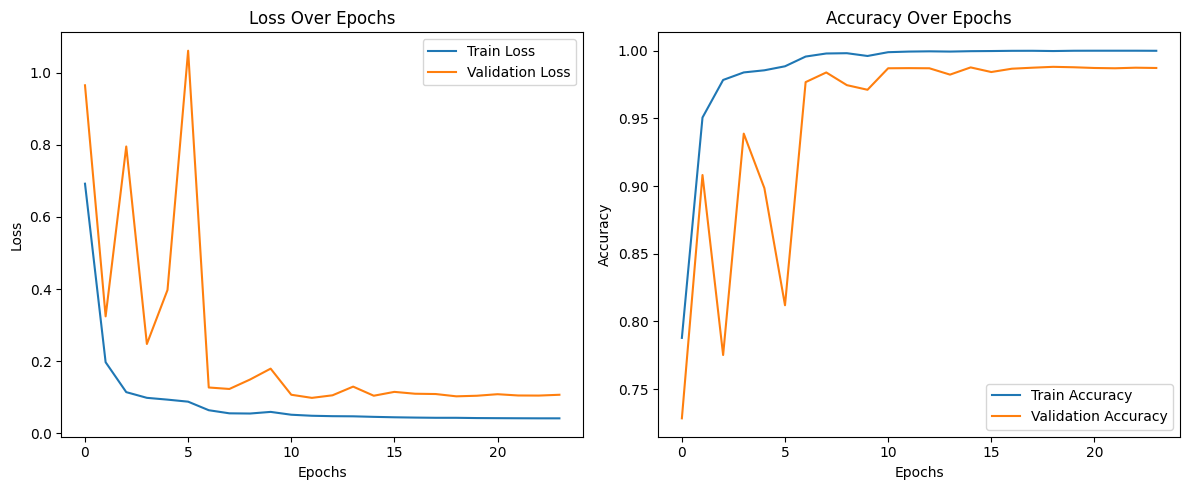

In [ ]:
# STEP 5: Build the Model
model = create_cnn_vit_xception()

# STEP 6: Compile the Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# STEP 7: Train the Model
callbacks = [
    ModelCheckpoint("best_hybrid_model.keras", save_best_only=True, monitor="val_accuracy", mode="max"),
    EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=64,
    epochs=50,
    callbacks=callbacks
)

# STEP 8: Plot Training History
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.tight_layout()
plt.show()


294/294 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.9893 - loss: 0.1032 - precision: 0.9896 - recall: 0.9893

Test Results:
loss: 0.1025
compile_metrics: 0.9881
294/294 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step

Classification Report:
              precision    recall  f1-score   support

       akiec       1.00      1.00      1.00      1295
         bcc       1.00      1.00      1.00      1323
         bkl       0.98      0.99      0.99      1351
          df       1.00      1.00      1.00      1392
         mel       0.96      0.99      0.97      1312
          nv       0.99      0.93      0.96      1346
        vasc       1.00      1.00      1.00      1368

    accuracy                           0.99      9387
   macro avg       0.99      0.99      0.99      9387
weighted avg       0.99      0.99      0.99      9387



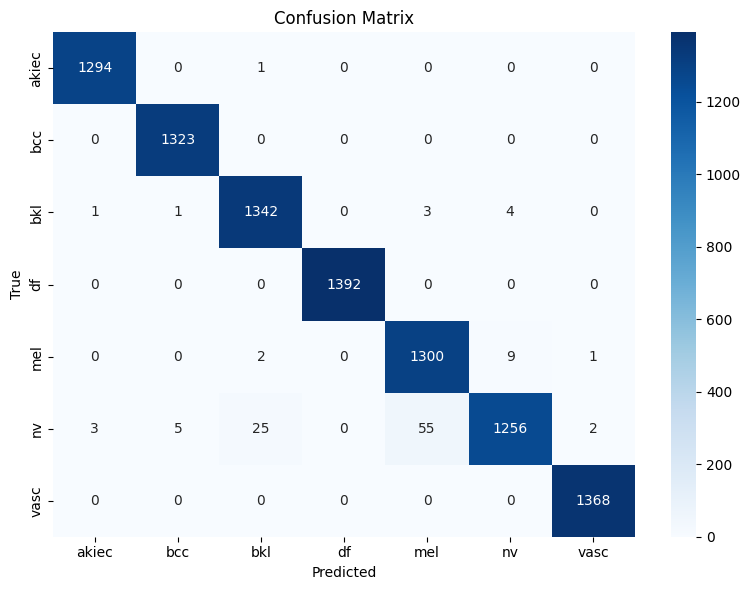

In [ ]:

# 9. Evaluate Model
results = model.evaluate(X_test, y_test, verbose=1)
print("\nTest Results:")
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value:.4f}")

# 10. Confusion Matrix and Classification Report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


In [ ]:
model.summary()


Model: "CNN_ViT_Xception_Hybrid"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 72, 72, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 35, 35,    │        864 │ input_image[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 35, 35,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 35, 35,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 33, 33,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 33, 33,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 33, 33,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 33, 33,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 33, 33,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 33, 33,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 33, 33,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 33, 33,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 17, 17,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 17, 17,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 17, 17,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 17, 17,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 17, 17,    │          0 │ add_9[0][0]     

 Total params: 72,473,615 (276.46 MB)

 Trainable params: 24,131,951 (92.06 MB)

 Non-trainable params: 77,760 (303.75 KB)

 Optimizer params: 48,263,904 (184.11 MB)

In [ ]:
# STEP 1: Print simple text summary
model.summary()



Model: "CNN_ViT_Xception_Hybrid"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 72, 72, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 35, 35,    │        864 │ input_image[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 35, 35,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 35, 35,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 33, 33,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 33, 33,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 33, 33,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 33, 33,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 33, 33,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 33, 33,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 33, 33,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 33, 33,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 17, 17,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 17, 17,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 17, 17,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 17, 17,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 17, 17,    │          0 │ add_9[0][0]     

 Total params: 72,473,615 (276.46 MB)

 Trainable params: 24,131,951 (92.06 MB)

 Non-trainable params: 77,760 (303.75 KB)

 Optimizer params: 48,263,904 (184.11 MB)

step 5 till end re-done + ROC curve

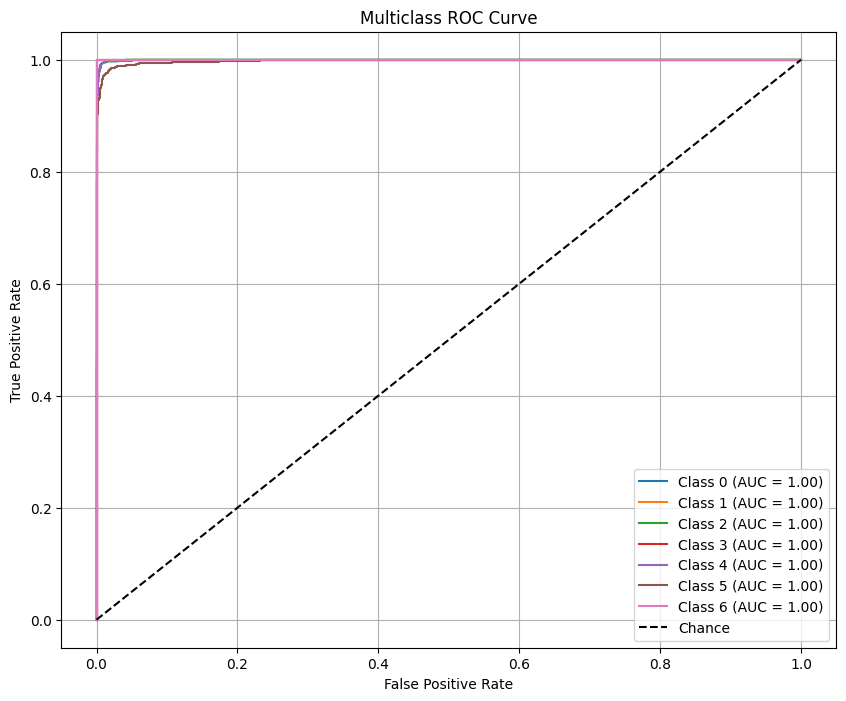

In [ ]:
# STEP 13: ROC Curve
from sklearn.metrics import roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt

n_classes = y_test.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
